In [1]:
import numpy as np
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.optimizers import Adam
# import tensorflow_probability as tfp
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, BatchNormalization
from tensorflow.keras.regularizers import l2
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_curve, auc
from uitils import *
from sklearn.metrics import roc_auc_score, accuracy_score, precision_recall_curve, auc, recall_score, f1_score

In [2]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  1


# Data Loading

In [3]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, y_train = extract_samples(x_train, y_train, 500)
x_test, y_test = extract_samples(x_test, y_test, 100)
print("Reduced training set shape:", x_train.shape)
print("Reduced testing set shape:", x_test.shape)
x_train = x_train / 255.0
x_test = x_test / 255.0
y_train = y_train % 2  # Convert labels to 0 (even) and 1 (odd) 
y_test = y_test % 2
s=y_train

# Initialize 's' to zeros, meaning initially all are unlabeled
s = np.zeros_like(y_train)

# Select a random 300 samples where y_train == 1 to be labeled
positive_indices = np.where(y_train == 1)[0]
chosen_indices = np.random.choice(positive_indices, size=1000, replace=False)

# Mark these as labeled in 's'
s[chosen_indices] = 1

# Mark the rest of the positive_indices except the chosen 300 as potential targets for unlabeled marking
rest_of_positives = np.setdiff1d(positive_indices, chosen_indices)

# From the rest, select 30% and mark their labels as 0 in y_train
number_to_mark_unlabeled = int(len(rest_of_positives) * 0.03)
# number_to_mark_unlabeled = int(1)
unlabeled_indices = np.random.choice(rest_of_positives, size=number_to_mark_unlabeled, replace=False)
y_train[unlabeled_indices] = 0

# Remove the rest of the positive rows that are not in the chosen 300 and not marked as unlabeled
indices_to_drop = np.setdiff1d(rest_of_positives, np.concatenate([chosen_indices, unlabeled_indices]))
x_train = np.delete(x_train, indices_to_drop, axis=0)
y_train = np.delete(y_train, indices_to_drop)
s = np.delete(s, indices_to_drop)

print("Training labels distribution:", np.bincount(y_train))
print("Training original labels distribution:", np.bincount(s))

Reduced training set shape: (5000, 28, 28)
Reduced testing set shape: (1000, 28, 28)
Training labels distribution: [2545 1000]
Training original labels distribution: [2545 1000]


In [4]:
# def create_pu_datasets(x, y, n_labeled, pos_fraction):
#     # Select a random 300 rows where y_train == 1
#     positive_indices = np.where(y_train == 1)[0]
#     chosen_indices = np.random.choice(positive_indices, size=n_labeled, replace=False)

#     # Mark the rest of the positive_indices except the chosen 300 as potential targets for unlabeled marking
#     rest_of_positives = np.setdiff1d(positive_indices, chosen_indices)

#     # From the rest, select 30% and mark their labels as 0
#     number_to_mark_unlabeled = int(len(rest_of_positives) * pos_fraction)
#     unlabeled_indices = np.random.choice(rest_of_positives, size=number_to_mark_unlabeled, replace=False)
#     y_train[unlabeled_indices] = 0

#     # Remove the rest of the rows where y=1 that are not in the chosen 300
#     indices_to_drop = np.setdiff1d(rest_of_positives, unlabeled_indices)
#     x_train = np.delete(x_train, indices_to_drop, axis=0)
#     y_train = np.delete(y_train, indices_to_drop)

#     return x_train, y_train

# # Create datasets as per specifications from the paper
# # configs = [(300, 0.3), (500, 0.5), (1000, 0.7)]
# configs = [(300, 0.3)]
# datasets = [create_pu_datasets(x_train, y_train, n, frac) for n, frac in configs]

# for i, (train_x_pu, train_y_pu) in enumerate(datasets):
#     print(f"Configuration {i+1} label distribution: {np.bincount(train_y_pu.astype(int))}")

# Pre-training

In [5]:
weight_decay = 2.0
model_1 = Sequential([
    Conv2D(128, (3, 3), padding='same', input_shape=(28, 28, 1), kernel_regularizer=l2(weight_decay)),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(64, (3, 3), padding='same', kernel_regularizer=l2(weight_decay)),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(32, (1, 1), padding='same', kernel_regularizer=l2(weight_decay)),
    BatchNormalization(),
    Activation('relu'),
    Flatten(),
    Dense(16, kernel_regularizer=l2(weight_decay)),
    Activation('relu'),
    Dense(10, kernel_regularizer=l2(weight_decay)),
    Activation('relu'),
    Dense(1, kernel_regularizer=l2(weight_decay)),
    Activation('sigmoid')
])


model_1.compile(optimizer=Adam(learning_rate=0.00001), loss='binary_crossentropy', metrics=['accuracy'])
history_1 = model_1.fit(x_train, y_train, epochs=15, batch_size=128, validation_split=0.2)
# model_1.save_weights('clf_model_.weights.h5')
# model_1.load_weights('clf_model_.weights.h5')


Epoch 1/15
23/23 [==============================] - 57s 1s/step - loss: 349.2628 - accuracy: 0.4475 - val_loss: 346.5315 - val_accuracy: 0.5458
Epoch 2/15
23/23 [==============================] - 16s 730ms/step - loss: 344.2337 - accuracy: 0.6439 - val_loss: 341.6066 - val_accuracy: 0.5430
Epoch 3/15
23/23 [==============================] - 20s 722ms/step - loss: 339.3407 - accuracy: 0.7147 - val_loss: 336.8028 - val_accuracy: 0.5261
Epoch 4/15
23/23 [==============================] - 16s 729ms/step - loss: 334.5699 - accuracy: 0.7567 - val_loss: 332.1226 - val_accuracy: 0.5515
Epoch 5/15
23/23 [==============================] - 16s 718ms/step - loss: 329.9194 - accuracy: 0.7821 - val_loss: 327.5630 - val_accuracy: 0.5472
Epoch 6/15
23/23 [==============================] - 16s 723ms/step - loss: 325.3863 - accuracy: 0.7980 - val_loss: 323.1222 - val_accuracy: 0.5430
Epoch 7/15
23/23 [==============================] - 16s 717ms/step - loss: 320.9694 - accuracy: 0.8078 - val_loss: 318.79

### Probablistic outcome of classifer to pre-train policy network
 

In [6]:
probabilities = model_1.predict(x_train)
threshold = min(probabilities[y_train == 1])
print(f"Threshold: {threshold}")
# Convert probabilities to binary labels based on the threshold
predicted_labels = (probabilities >= threshold).astype(int)
clf_predicted_labels = predicted_labels.flatten().astype(int)

print("Classifer predicted labels distribution:", np.bincount(clf_predicted_labels))

111/111 [==============================] - 11s 94ms/step
Threshold: [0.44182795]
Classifer predicted labels distribution: [  62 3483]


32/32 [==============================] - 5s 154ms/step


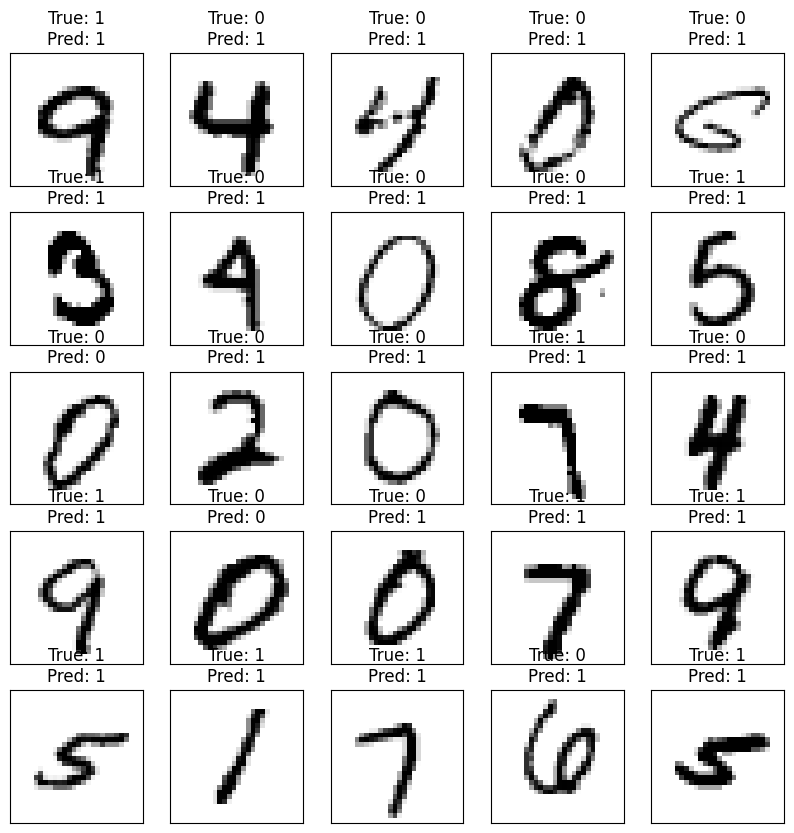

In [7]:
# print(list(probabilities))

# Predictions from the second classifier
predictions = model_1.predict(x_test)
predicted_classes = (predictions > 0.5).astype(int).flatten()  # Assuming binary classification

# Selecting a few images to display
indices = np.random.choice(range(len(x_test)), 25, replace=False)  # Randomly select 25 images
selected_images = x_test[indices]
selected_labels = y_test[indices]
selected_predictions = predicted_classes[indices]

# Plotting
plot_images(selected_images, selected_labels, selected_predictions)

In [8]:
print(list(y_train))

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [9]:
# Policy-Network Model

class PolicyGradientNetwork:
    def __init__(self):
        self.model = self._create_model()
    
    def _create_model(self):
        weight_decay = 0.5
        model = Sequential([
            Conv2D(96, (3, 3), padding='same', input_shape=(28, 28, 1), kernel_regularizer=l2(weight_decay)),
            Activation('relu'),
            Conv2D(64, (3, 3), padding='same', kernel_regularizer=l2(weight_decay)),
            Activation('relu'),
            Flatten(),
            Dense(100, kernel_regularizer=l2(weight_decay)),
            Activation('relu'),
            Dense(10, kernel_regularizer=l2(weight_decay)),  # Additional Dense layer
            Activation('relu'),
            Dense(1, kernel_regularizer=l2(weight_decay)),  # Softmax output for binary classification
            Activation('sigmoid') # Hard labeling
        ])
        return model
    
    def get_model(self):
        return self.model
    

policy_network = PolicyGradientNetwork()
pn_model = policy_network.get_model()

pn_model.compile(optimizer=Adam(learning_rate=0.00001), loss='binary_crossentropy', metrics=['accuracy'])

history_2 = pn_model.fit(x_train, clf_predicted_labels, epochs=5, batch_size=128, validation_split=0.2)
# pn_model.save_weights('pn_model_.weights.h5')
# pn_model.load_weights('pn_model_.weights.h5')

Epoch 1/5
23/23 [==============================] - 26s 723ms/step - loss: 145.8770 - accuracy: 0.9446 - val_loss: 142.3364 - val_accuracy: 0.9986
Epoch 2/5
23/23 [==============================] - 11s 495ms/step - loss: 139.4155 - accuracy: 0.9785 - val_loss: 136.0515 - val_accuracy: 0.9986
Epoch 3/5
23/23 [==============================] - 15s 674ms/step - loss: 133.2929 - accuracy: 0.9785 - val_loss: 130.1075 - val_accuracy: 0.9986
Epoch 4/5
23/23 [==============================] - 11s 486ms/step - loss: 127.5066 - accuracy: 0.9785 - val_loss: 124.4918 - val_accuracy: 0.9986
Epoch 5/5
23/23 [==============================] - 15s 680ms/step - loss: 122.0401 - accuracy: 0.9785 - val_loss: 119.1858 - val_accuracy: 0.9986


In [10]:
probabilities = pn_model.predict(x_train)
threshold = min(probabilities[y_train == 1])
print(f"Threshold: {threshold}")
# Convert probabilities to binary labels based on the threshold
predicted_labels = (probabilities >= threshold).astype(int)
np_predicted_labels = predicted_labels.flatten().astype(int)

print("Classifer predicted labels distribution:", np.bincount(np_predicted_labels))

111/111 [==============================] - 10s 91ms/step
Threshold: [0.54608524]
Classifer predicted labels distribution: [   0 3545]


## Interactive learning

In [11]:
import tensorflow as tf
import numpy as np

class Agent:
    def __init__(self, model, target_model, alpha=0.00001, gamma=0.99):
        self.gamma = gamma  # Discount factor
        self.lr = alpha  # Learning rate
        self.model = model  # Policy model
        self.target_model = target_model # target policy model
        self.state_memory = []
        self.action_memory = []
        self.reward_memory = []

    def choose_action(self, states, s, threshold=0.5):
        # Convert states to float32 tensor within the function
        states = tf.convert_to_tensor(states, dtype=tf.float32)
        probabilities = self.target_model(states)  # Make sure target model expects float32 input
        # action_sampler = tfp.distributions.Bernoulli(probs=probabilities, dtype=tf.float32)
        # actions = action_sampler.sample()
        # print(f"probabilities ={probabilities}")
        # actions = tf.cast(tf.random.uniform(tf.shape(probabilities)) < probabilities, tf.int32)

        inferred_labels = tf.cast(probabilities > threshold, tf.int32)       
        s = tf.reshape(s, tf.shape(inferred_labels))  # Ensuring s is the same shape as inferred_labels
        actions = tf.where(s == 1, 1, inferred_labels)
        actions = tf.squeeze(actions)  # This should correctly squeeze actions to shape (128,)
        return actions.numpy(), probabilities.numpy()


    def store_transition(self, states, actions, rewards):
        self.state_memory.extend(states)
        self.action_memory.extend(actions)
        self.reward_memory.extend(rewards)

    def learn(self):
        actions = np.array(self.action_memory)
        rewards = np.array(self.reward_memory)
        states = np.array(self.state_memory)

        # Calculate discounted rewards
        G = np.zeros_like(rewards)
        for t in range(len(rewards)):
            G_sum = 0
            discount = 1
            for k in range(t, len(rewards)):
                G_sum += rewards[k] * discount
                discount *= self.gamma
            G[t] = G_sum

        # Updating policy
        with tf.GradientTape() as tape:
            loss = 0
            for idx, (g, state) in enumerate(zip(G, states)):
                state = tf.convert_to_tensor([state], dtype=tf.float32)
                probs = self.model(state, training=True)
                # action_probs = tfp.distributions.Bernoulli(probs=probs)
                # log_prob = action_probs.log_prob(actions[idx])
                # loss += -g * tf.reduce_sum(log_prob)
                action_probs = tf.where(actions[idx] == 1, probs, 1 - probs)
                log_prob = tf.math.log(action_probs)
                loss += -g * tf.reduce_sum(log_prob)

        gradients = tape.gradient(loss, self.model.trainable_variables)
        self.model.optimizer.apply_gradients(zip(gradients, self.model.trainable_variables))

        # Clear memory
        self.state_memory = []
        self.action_memory = []
        self.reward_memory = []


In [12]:
# Clone policy model for stable target policy
target_policy_model = tf.keras.models.clone_model(pn_model)
target_policy_model.compile(optimizer=Adam(learning_rate=0.00001), loss='binary_crossentropy', metrics=['accuracy'])

history = {
    'epoch_loss': [],
    'epoch_accuracy': [],
    'batch_loss': [],
    'batch_accuracy': [],
    'predictions': [],
    'rewards': [],
    'thresholds': [],
    'ROC_AUC': [],
    'accuracy':[],
    'PR_AUC':[],
    'recall':[],
    'f1':[]
}
agent = Agent(pn_model,target_model=target_policy_model, alpha=0.00001, gamma=0.99)
# Example parameters
n_epochs = 300
n_epochs = 10
batch_size = 128 # You can adjust the batch size as needed

def shuffle_data(x_train, y_train, s):
    indices = np.arange(len(x_train))
    np.random.shuffle(indices)
    return x_train[indices], y_train[indices], s[indices]

def create_mini_batches(x_train, y_train, s, batch_size):
    for start_idx in range(0, len(x_train) - batch_size + 1, batch_size):
        excerpt = slice(start_idx, start_idx + batch_size)
        yield x_train[excerpt], y_train[excerpt], s[excerpt]

def calculate_threshold(clf_probabilities, y_batch):
    # Identify indices of positive examples
    positive_indices = (y_batch == 1)
    
    # Calculate threshmin from positive examples
    if np.any(positive_indices):
        threshmin = np.min(clf_probabilities[positive_indices])
    else:
        threshmin = 0  # Default value if no positive examples are present

    # Identify U0 - samples with predictions >= threshmin
    U0_indices = (clf_probabilities >= threshmin)
    
    # Calculate the final threshold using Equation 5
    if np.any(U0_indices):
        threshold = np.mean(clf_probabilities[U0_indices])
    else:
        threshold = threshmin  # Use threshmin if no samples meet the U0 criteria

    return threshold

def calculate_rewards(clf_probabilities, y_batch, threshold):
    # Reward calculation needs to consider whether predictions meet a certain threshold
    # Positive examples above threshold or negative examples below threshold get positive rewards
    rewards = []
    for prob, actual in zip(clf_probabilities.flatten(), y_batch):
        if actual == 1 or (actual == 0 and prob >= threshold):
            reward = prob  # Reward is the probability itself if conditions are met
        else:
            reward = prob -1  # Otherwise, reward is the complement of the probability
        rewards.append(reward)
    return rewards

In [13]:
def train_model(x_train, y_train, s, epochs=300, batch_size=128, min_delta=0.0001, patience=10):
    x_train = x_train.astype('float32')
    y_train = y_train.astype('float32')
    s = s.astype('float32')

    dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train, s))
    dataset = dataset.shuffle(buffer_size=len(x_train)).batch(batch_size)

    # early_stopping = EarlyStopping(monitor='val_accuracy', patience=patience, min_delta=min_delta, mode='max', restore_best_weights=True, verbose=1)

    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        epoch_loss = 0
        epoch_accuracy = 0
        batch_count = 0
        # first_iteration = True
        # threshold_pass = 0.5
        threshold = 0.5
        for x_batch, y_batch, s_batch in dataset:
            # Get actions and probabilities for the entire batch
            actions, probabilities = agent.choose_action(x_batch, s_batch, threshold=threshold)

            # Fit the model on the current batch and update history
            batch_history = model_1.fit(x_batch, actions, epochs=1, batch_size=len(x_batch), validation_split=0.2, verbose=0)
            history['batch_loss'].append(batch_history.history['loss'][0])
            history['batch_accuracy'].append(batch_history.history['accuracy'][0])
            epoch_loss += batch_history.history['loss'][0]
            epoch_accuracy += batch_history.history['accuracy'][0]
            batch_count += 1

            clf_probabilities = model_1.predict(x_batch)
            threshold = calculate_threshold(clf_probabilities, y_batch)
            rewards = calculate_rewards(clf_probabilities, y_batch, threshold)
            agent.store_transition(x_batch.numpy(), actions, rewards)
            agent.learn()
            # break
        first_iteration = True
        epoch_loss /= batch_count
        epoch_accuracy /= batch_count
        history['epoch_loss'].append(epoch_loss)
        history['epoch_accuracy'].append(epoch_accuracy)
        print(f"Epoch {epoch+1}: Loss = {epoch_loss}, Accuracy = {epoch_accuracy}")

        # early stopping condition
        # if epoch > 0 and (history['epoch_accuracy'][-1] - history['epoch_accuracy'][-2]) < min_delta:
        #     print("Early stopping triggered.")
        #     break

        probabilities = model_1.predict(x_test)  # Ensure this is the probability of the positive class
        roc_auc = roc_auc_score(y_true=y_test, y_score=probabilities)
        history['ROC_AUC'].append(roc_auc)
        # Predict probabilities for the positive class
        # probabilities = model_1.predict(x_test)
        precision, recall, _ = precision_recall_curve(y_true=y_test, probas_pred=probabilities)
        pr_auc = auc(recall, precision)
        history['PR_AUC'].append(pr_auc)
        # predictions = (model_1.predict(x_test) > 0.5).astype(int)
        predictions = (probabilities > 0.5).astype(int)
        accuracy = accuracy_score(y_true=y_test, y_pred=predictions)
        history['accuracy'].append(pr_auc)

        recall_value = recall_score(y_true=y_test, y_pred=predictions)
        history['recall'].append(recall_value)

        # Calculate F1 score
        f1 = f1_score(y_true=y_test, y_pred=predictions)
        history['f1'].append(f1)
        print("ROC AUC Score:", roc_auc)
        print("Accuracy Score:", accuracy)
        print("Precision-Recall AUC:", pr_auc)
        print("Recall:", recall_value)
        print("F1 Score:", f1)
        

        if epoch % 3 == 0:
            print("Updating target policy...")
            agent.target_model.set_weights(agent.model.get_weights())


train_model(x_train=x_train, y_train=y_train, s=s)

Epoch 1/300
3/3 [==============================] - 0s 23ms/step
Epoch 1: Loss = 285.51869310651506, Accuracy = 0.8176460681217057
32/32 [==============================] - 5s 152ms/step
ROC AUC Score: 0.8613839999999999
Accuracy Score: 0.685
Precision-Recall AUC: 0.8547282811277249
Recall: 0.956
F1 Score: 0.7521636506687648
Updating target policy...
Epoch 2/300
3/3 [==============================] - 0s 12ms/step
Epoch 2: Loss = 281.478513445173, Accuracy = 0.7038949307586465
32/32 [==============================] - 0s 13ms/step
ROC AUC Score: 0.7165600000000001
Accuracy Score: 0.5
Precision-Recall AUC: 0.7079644439830854
Recall: 1.0
F1 Score: 0.6666666666666666
Epoch 3/300
3/3 [==============================] - 0s 9ms/step
Epoch 3: Loss = 277.02569580078125, Accuracy = 0.9381583482027054
32/32 [==============================] - 1s 16ms/step
ROC AUC Score: 0.630012
Accuracy Score: 0.5
Precision-Recall AUC: 0.6168829688982154
Recall: 1.0
F1 Score: 0.6666666666666666
Epoch 4/300
3/3 [=====

In [ ]:
import pickle
with open('history_2.pkl', 'wb') as file:
    # Use pickle to dump the dictionary into the file
    pickle.dump(history, file)

with open('history_2.pkl', 'rb') as file:
    # Load the dictionary back from the pickle file
    loaded_history = pickle.load(file)

# Verify the content
print(loaded_history)

In [ ]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_curve, auc
# Predict probabilities for the positive class
probabilities = model_1.predict(x_test)  # Ensure this is the probability of the positive class
roc_auc = roc_auc_score(y_true=y_test, y_score=probabilities)
print("ROC AUC Score:", roc_auc)

# Predict class labels based on a threshold, typically 0.5 for binary classifiers
predictions = (model_1.predict(x_test) > 0.5).astype(int)
accuracy = accuracy_score(y_true=y_test, y_pred=predictions)
print("Accuracy Score:", accuracy)

# Predict probabilities for the positive class
probabilities = model_1.predict(x_test)
precision, recall, _ = precision_recall_curve(y_true=y_test, probas_pred=probabilities)
pr_auc = auc(recall, precision)
print("Precision-Recall AUC:", pr_auc)

In [ ]:
target_policy_model.save_weights('target_policy_model_2.weights.h5')
model_1.save_weights('clf_model_after_IL_2.weights.h5')

history = {
    'epoch_loss': [],
    'epoch_accuracy': [],
    'batch_loss': [],
    'batch_accuracy': [],
    'predictions': [],
    'rewards': [],
    'thresholds': [],
    'ROC_AUC': [],
    'accuracy':[],
    'PR_AUC':[]
}

In [ ]:
import matplotlib.pyplot as plt

# Plotting epoch losses and accuracies
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history['epoch_loss'], label='Loss')
plt.title('Epoch Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['epoch_accuracy'], label='Accuracy')
plt.title('Epoch Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# You can add more plots for batch-level data, rewards, thresholds, etc.


# Visual

In [ ]:
# Plotting epoch losses and accuracies
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history['batch_loss'], label='Loss')
plt.title('Batch Loss')
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['batch_accuracy'], label='Accuracy')
plt.title('Batch Accuracy')
plt.xlabel('Batch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [ ]:
# Plotting epoch losses and accuracies 'ROC_AUC': [],
    # 'accuracy':[],
    # 'PR_AUC':[]
plt.figure(figsize=(14, 5))

plt.subplot(1, 3, 1)
plt.plot(history['ROC_AUC'], label='Loss')
plt.title('ROC AUC')
plt.xlabel('Epoch')
plt.ylabel('ROC')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(history['accuracy'], label='Accuracy')
plt.title('Epoch Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(history['PR_AUC'], label='Accuracy')
plt.title('PR AUC')
plt.xlabel('Epoch')
plt.ylabel('PR@Epoch')
plt.legend()


In [ ]:


# Predictions from the second classifier
predictions = target_policy_model.predict(x_test)
predicted_classes = (predictions > 0.5).astype(int).flatten()  # Assuming binary classification

# Selecting a few images to display
indices = np.random.choice(range(len(x_test)), 25, replace=False)  # Randomly select 25 images
selected_images = x_test[indices]
selected_labels = y_test[indices]
selected_predictions = predicted_classes[indices]

# Plotting
plot_images(selected_images, selected_labels, selected_predictions)


In [ ]:
def plot_history(history):
    """Plot training and validation loss and accuracy."""
    fig, axs = plt.subplots(2, 1, figsize=(10, 10))
    axs[0].plot(history.history['loss'], label='train')
    axs[0].plot(history.history['val_loss'], label='validation')
    axs[0].set_title('Loss')
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Loss')
    axs[0].legend()

    axs[1].plot(history.history['accuracy'], label='train')
    axs[1].plot(history.history['val_accuracy'], label='validation')
    axs[1].set_title('Accuracy')
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('Accuracy')
    axs[1].legend()

    plt.show()

# Assuming you have stored the history of training your models as `history_1` and `history_2`
plot_history(history_1)  # For the first classifier
plot_history(history_2)  # For the second classifier
